In [1]:
%cd ..

/home/alberto/Work/incomplete_multiview_clustering


/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Tutorial: Impute incomplete modality and feature-wise multi-modal data

## Prerequisites

You’ll need the following libraries installed: matplotlib; seaborn

## Step 1: Import required libraries

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from imvc.datasets import LoadDataset
from imvc.impute import MOFAImputer, jNMFImputer, get_observed_view_indicator
from imvc.preprocessing import MultiViewTransformer, NormalizerNaN
from imvc.ampute import Amputer
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from tueplots import axes, bundles
plt.rcParams.update(**bundles.icml2022(), **axes.lines())
for key in ["axes.labelsize", "axes.titlesize", "font.size", "legend.fontsize", "xtick.labelsize", "ytick.labelsize"]:
    if key == "legend.fontsize":
        plt.rcParams[key] += 3
    else:
        plt.rcParams[key] += 6

## Step 2: Load the dataset

We'll use the sensIT300 dataset, a multi-view dataset with 300 samples and 2 modalities, to demonstrate how to handle multi-view data. Each view represents a distinct set of features for the same set of samples.

In [5]:
Xs = LoadDataset.load_dataset(dataset_name="sensIT300")
print("Samples:", len(Xs[0]), "\t", "Modalities:", len(Xs), "\t", "Features:", [X.shape[1] for X in Xs])

Samples: 300 	 Modalities: 2 	 Features: [50, 50]


## Step 3: Apply missing data mechanism (Amputation)

Using Amputer, we randomly introduce missing data to simulate a scenario where some modalities are missing. Here, 30% of the samples will be incomplete.

In [ ]:
amputed_Xs = Amputer(p= 0.3, mechanism="mcar", random_state=42).fit_transform(Xs)

You can visualize which modalities are missing using a binary color map.

In [ ]:
xlabel,ylabel = "Modality", "Samples"
observed_view_indicator = get_observed_view_indicator(amputed_Xs).sort_values(list(range(len(amputed_Xs))))
plt.pcolor(observed_view_indicator, cmap="binary")
plt.xticks(np.arange(0.5, len(observed_view_indicator.columns), 1), observed_view_indicator.columns)
_ = plt.xlabel(xlabel), plt.ylabel(ylabel)

## Step 4: Impute missing data 

We are going to apply a pipeline that consists of the following steps: Standardization of the features; Imputation of missing modalities using MOFAImputer, a method designed for multi-view data imputation.

In [ ]:
pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                         MOFAImputer(n_components = 8, random_state=42).set_output(transform="pandas"))
imputed_Xs = pipeline.fit_transform(amputed_Xs)

You can again visualize the dataset after imputation to observe the filled modalities.

In [ ]:
observed_view_indicator = get_observed_view_indicator(imputed_Xs).sort_values(list(range(len(imputed_Xs))))
plt.pcolor(observed_view_indicator, cmap="binary_r")
plt.xticks(np.arange(0.5, len(observed_view_indicator.columns), 1), observed_view_indicator.columns)
_ = plt.xlabel(xlabel), plt.ylabel(ylabel)

## Step 5: Evaluate the imputation performance

We will calculate the Mean Squared Error (MSE) between the true values (before amputation) and the imputed values, restricted to the places where data were missing. The MSE helps quantify how well the imputation was performed. In addition to the MOFA-based pipeline, we introduce a baseline imputation method that uses SimpleImputer to fill in missing values with the average.

Define a range of missingness proportions (ps), and vary the number of components for MOFAImputer (n_components_list). We will generate both block- and feature-wise missing data, and perform multiple runs for robustness.

In [6]:
ps = np.arange(0.1, .8, 0.2)
n_components_list = [1, 2, 4, 8, 16, 32]
# mechanisms = ["um", "pm", "mcar", "mnar"]
mechanisms = ["um", "mcar"]
n_times = 5
algorithms = ["MOFAImputer", "jNMFImputer"]
methods = ["Original", "Baseline", "Filling"]
all_metrics = {}

In [7]:
# for algorithm in tqdm(algorithms):
#     all_metrics[algorithm] = {}
#     for method in tqdm(methods):
#         all_metrics[algorithm][method] = {}
#         for mechanism in tqdm(mechanisms):
#             all_metrics[algorithm][method][mechanism] = {}
#             for p in ps:
#                 missing_percentage = int(p*100)
#                 all_metrics[algorithm][method][mechanism][missing_percentage] = {}
#                 for n_components in n_components_list:
#                     all_metrics[algorithm][method][mechanism][missing_percentage][n_components] = {}
#                     for i in range(n_times):
#                         all_metrics[algorithm][method][mechanism][missing_percentage][n_components][i] = {}
#                         alg = eval(algorithm)
#                         if algorithm == "MOFAImputer":
#                             normalizer = StandardScaler()
#                         elif algorithm == "jNMFImputer":
#                             normalizer = MinMaxScaler()
#                         pipeline = make_pipeline(
#                             MultiViewTransformer(normalizer.set_output(transform="pandas")),
#                             alg(n_components = n_components, random_state=i))
#                         if method == "Baseline":
#                             pipeline = make_pipeline(
#                                 MultiViewTransformer(SimpleImputer().set_output(transform="pandas")),
#                                 *pipeline)
#                         elif method == "Filling":
#                             pipeline = make_pipeline(
#                                 MultiViewTransformer(SimpleImputer().set_output(transform="pandas")),
#                                 pipeline[0])
#                         amputed_Xs = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
#                         for X in amputed_Xs:
#                             X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
#                         masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
#                         try:
#                             imputed_Xs = pipeline.fit_transform(amputed_Xs)
#                             transformed_Xs = pipeline[:-1].transform(Xs)
#                             metric = np.mean([mean_squared_error(transformed_X.values[mask], imputed_X.values[mask])
#                                               for transformed_X,imputed_X,mask in zip(transformed_Xs, imputed_Xs, masks)])
#                             all_metrics[algorithm][method][mechanism][missing_percentage][n_components][i]["Mean Squared Error"] = metric
#                             all_metrics[algorithm][method][mechanism][missing_percentage][n_components][i]["Comments"] = ""
#                         except Exception as ex:
#                             all_metrics[algorithm][method][mechanism][missing_percentage][n_components][i]["Comments"] = ex

In [8]:
for algorithm in tqdm(algorithms):
    all_metrics[algorithm] = {}
    for method in tqdm(methods):
        all_metrics[algorithm][method] = {}
        for mechanism in tqdm(mechanisms):
            all_metrics[algorithm][method][mechanism] = {}
            for p in ps:
                missing_percentage = int(p*100)
                all_metrics[algorithm][method][mechanism][missing_percentage] = {}
                for n_components in n_components_list:
                    all_metrics[algorithm][method][mechanism][missing_percentage][n_components] = {}
                    for i in range(n_times):
                        all_metrics[algorithm][method][mechanism][missing_percentage][n_components][i] = {}
                        alg = eval(algorithm)
                        if algorithm == "MOFAImputer":
                            normalizer = StandardScaler()
                        elif algorithm == "jNMFImputer":
                            normalizer = MinMaxScaler()
                        pipeline = make_pipeline(
                            MultiViewTransformer(normalizer.set_output(transform="pandas")),
                            alg(n_components = n_components, random_state=i))
                        if method == "Baseline":
                            pipeline = make_pipeline(
                                MultiViewTransformer(SimpleImputer().set_output(transform="pandas")),
                                *pipeline)
                        elif method == "Filling":
                            pipeline = make_pipeline(
                                MultiViewTransformer(SimpleImputer().set_output(transform="pandas")),
                                pipeline[0])
                        amputed_Xs = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
                        for X in amputed_Xs:
                            X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
                        masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
                        try:
                            imputed_Xs = pipeline.fit_transform(amputed_Xs)
                            if method == "Filling":
                                transformer_list = pipeline[-1].transformer_list_
                            else:
                                transformer_list = pipeline[-2].transformer_list_
                            imputed_Xs = [pd.DataFrame(transformer.inverse_transform(X), index=X.index, columns=X.columns)
                                          for X, transformer in zip(imputed_Xs, transformer_list)]
                            metric = np.mean([mean_absolute_error(transformed_X.values[mask], imputed_X.values[mask])
                                              for transformed_X,imputed_X,mask in zip(Xs, imputed_Xs, masks)])
                            all_metrics[algorithm][method][mechanism][missing_percentage][n_components][i]["Mean Squared Error"] = metric
                            all_metrics[algorithm][method][mechanism][missing_percentage][n_components][i]["Comments"] = ""
                        except Exception as ex:
                            all_metrics[algorithm][method][mechanism][missing_percentage][n_components][i]["Comments"] = ex

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
flattened_data = [
    {
        'Algorithm': algorithm,
        'Method': method,
        'Missing rate (\%)': p,
        'Mechanism': mechanism,
        'Components': n_components,
        'Iteration': i,
        **iter_dict
    }
    for algorithm, algorithm_dict in all_metrics.items()
    for method, method_dict in algorithm_dict.items()
    for mechanism, mechanism_dict in method_dict.items()
    for p, p_dict in mechanism_dict.items()
    for n_components, n_components_dict in p_dict.items()
    for i, iter_dict in n_components_dict.items()
]
df = pd.DataFrame(flattened_data)
df = df.sort_values(["Algorithm", "Method", "Mechanism", "Missing rate (\%)", "Components", "Iteration"], ascending=[True, False, False, True, True, True])
df

,Algorithm,Method,Missing rate (\%),Mechanism,Components,Iteration,Mean Squared Error,Comments
0,MOFAImputer,Original,10,um,1,0,0.079613,
1,MOFAImputer,Original,10,um,1,1,0.075569,
2,MOFAImputer,Original,10,um,1,2,0.072134,
3,MOFAImputer,Original,10,um,1,3,0.069356,
4,MOFAImputer,Original,10,um,1,4,0.074767,
...,...,...,...,...,...,...,...,...
1195,jNMFImputer,Baseline,70,mcar,32,0,0.081830,
1196,jNMFImputer,Baseline,70,mcar,32,1,0.082940,
1197,jNMFImputer,Baseline,70,mcar,32,2,0.081571,
1198,jNMFImputer,Baseline,70,mcar,32,3,0.082207,


In [10]:
errors = df[df["Comments"] != ""]
print("errors", errors.shape)
errors

errors (0, 8)


,Algorithm,Method,Missing rate (\%),Mechanism,Components,Iteration,Mean Squared Error,Comments


In [11]:
df["Split"] = df["Algorithm"] + df["Method"]
colorblind_palette = sns.color_palette("colorblind")
n_estimators = df["Algorithm"].unique()
estimator_colors_dict = {estimator:colorblind_palette[i] for i, estimator in enumerate(n_estimators)}
estimator_colors_dict = {mix: col for mix in df["Split"] for est, col in estimator_colors_dict.items() if est in mix}
estimator_markers_dict = {estimator:["o", "+"][i] for i, estimator in enumerate(n_estimators)}
estimator_markers_dict = {mix: col for mix in df["Split"] for meth, col in estimator_markers_dict.items() if meth in mix}
method_linestyles_dict = {"Original": "-", "Baseline": "--", "Filling": "-."}
method_linestyles_dict = {mix: col for mix in df["Split"] for meth, col in method_linestyles_dict.items() if meth in mix}
mechanism_names = {"um": "Unpaired missing", "pm": "Partial missing", "mnar": "Missing not at random", "mcar": "Missing completely at random"}

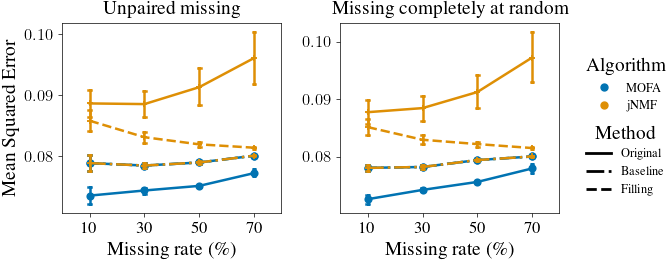

In [12]:
g = sns.FacetGrid(data=df, col="Mechanism", legend_out=False, sharey=False,
                  despine= False).map_dataframe(sns.pointplot, x="Missing rate (\%)",
                                                                    y="Mean Squared Error", hue="Split", 
                                                                    capsize= 0.05, seed= 42,
                                                                    palette= estimator_colors_dict,
                                                                    linestyles= list(method_linestyles_dict.values()),
                                                                    markers=list(estimator_markers_dict.values()))

handles = [plt.Line2D([0], [0], marker=marker, color=col, lw=0, markersize=5, markerfacecolor=col)
           for i, (_, col, marker) in enumerate(zip(n_estimators, colorblind_palette, list(estimator_markers_dict.values())))]
g.fig.legend(handles=handles, labels=[x.rstrip("Imputer") for x in n_estimators], title="Algorithm",
             bbox_to_anchor=(0.99, 0.65), loc="center left", frameon=False)
handles = [plt.Line2D([0], [0], color='black', lw=2, linestyle=linestyle)
           for linestyle in method_linestyles_dict.values()]
g.fig.legend(handles=handles, labels=methods, title="Method",
             bbox_to_anchor=(0.99, 0.4), loc="center left", frameon=False)

for i, mechanism in enumerate(df["Mechanism"].unique()):
    g.axes[0][i].set_title(mechanism_names[mechanism])
    # g.axes.flatten()[i].set_xlim((-0.2, 4.2))

plt.tight_layout()

In [ ]:
from imvc.impute import MOFAImputer, get_observed_view_indicator, jNMFImputer
from imvc.preprocessing import NormalizerNaN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
key = "jNMFImputer"
all_metrics[key] = {}
for p in tqdm(ps):
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     jNMFImputer(n_components = n_components, random_state=i))
            amputed_Xs = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
            for X in amputed_Xs:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
            imputed_Xs = pipeline.fit_transform(amputed_Xs)
            transformed_Xs = pipeline[0].transform(Xs)
            metric = np.mean([mean_absolute_error(transformed_X.values[mask], imputed_X[mask])
                              for transformed_X,imputed_X,mask in zip(transformed_Xs, imputed_Xs, masks)])
            all_metrics[key][missing_percentage][n_components][i] = metric

In [ ]:
key = "Baseline"
all_metrics[key] = {}
for p in tqdm(ps):
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                 MultiViewTransformer(SimpleImputer().set_output(transform="pandas")))
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            amputed_Xs = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
            for X in amputed_Xs:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
            imputed_Xs = pipeline.fit_transform(amputed_Xs)
            transformed_Xs = pipeline[0].transform(Xs)
            metric = np.mean([mean_absolute_error(transformed_X.values[mask], imputed_X.values[mask])
                              for transformed_X,imputed_X,mask in zip(transformed_Xs, imputed_Xs, masks)])
            all_metrics[key][missing_percentage][n_components][i] = metric

In [ ]:
key = "MOFA"
all_metrics[key] = {}
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                                     MOFAImputer(n_components = n_components, random_state=i).set_output(transform="pandas"))
            amputed_Xs = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
            for X in amputed_Xs:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
            imputed_Xs = pipeline.fit_transform(amputed_Xs)
            transformed_Xs = pipeline[0].transform(Xs)
            metric = np.mean([mean_squared_error(transformed_X.values[mask], imputed_X.values[mask]) for transformed_X,imputed_X,mask in zip(transformed_Xs, imputed_Xs, masks)])
            all_metrics[key][missing_percentage][n_components][i] = metric

In [ ]:
key = "Baseline"
all_metrics[key] = {}
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                                 MultiViewTransformer(SimpleImputer().set_output(transform="pandas")))
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            amputed_Xs = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
            for X in amputed_Xs:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
            imputed_Xs = pipeline.fit_transform(amputed_Xs)
            transformed_Xs = pipeline[0].transform(Xs)
            metric = np.mean([mean_squared_error(transformed_X.values[mask], imputed_X.values[mask]) for transformed_X,imputed_X,mask in zip(transformed_Xs, imputed_Xs, masks)])
            all_metrics[key][missing_percentage][n_components][i] = metric

## Step 6: Visualize the Results

After collecting the results from both the MOFA and Baseline imputation methods, we flatten the data into a structured format for easy comparison using visualizations.

In [ ]:
flattened_data = [
    {
        'Method': method,
        'Missing rate': p,
        'Components': n_comp,
        **n_dict
    }
    for method, method_dict in all_metrics.items()
    for p, p_dict in method_dict.items()
    for n_comp, n_dict in p_dict.items()
]
df = pd.DataFrame(flattened_data)
df = df.melt(id_vars=['Method', 'Missing rate', "Components"], var_name='Iteration', value_name='Imputation error (MSE)')
df = df.sort_values(["Missing rate", "Method", "Components", "Iteration"], ascending=[True, False, True, True])
# df.to_csv("tutorials/impute_results.csv", index= None)
df

In [ ]:
df.groupby(["Method", "Missing rate", "Components"]).mean()

We’ll use Seaborn to create point plots that show the imputation error for different levels of missing data and varying MOFA components.

In [ ]:
df = pd.read_csv("tutorials/impute_results.csv")
df

In [ ]:
fig, axs = plt.subplots(2, len(n_components_list), figsize=(20, 3))
fig.supylabel("Imputation error (MSE)", fontsize=plt.rcParams["axes.labelsize"])

for idx, components in enumerate(n_components_list):
    ax = axs[0, idx]
    ax2 = axs[1, idx]
    ax.set_title(f'Components = {components}', fontsize=plt.rcParams["axes.labelsize"])
    
    sns.pointplot(data=df, x="Missing rate (\%)", y="Imputation error (MSE)", hue="Method", markers=["o", "X"],
                  linestyles=["-", "--"], seed= 42, capsize= 0.05, palette= "tab10", ax=ax)
    sns.pointplot(data=df, x="Missing rate (\%)", y="Imputation error (MSE)", hue="Method", markers=["o", "X"],
                  linestyles=["-", "--"], seed= 42, capsize= 0.05, palette= "tab10", ax=ax2)

    
    ax.set_ylim(4, 6)
    ax2.set_ylim(1, 1.8)

    ax.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax.get_xaxis().set_visible(False)
    if components == min(n_components_list):
        ax.get_legend().set_title(None)
        ax.legend(loc='upper left')
        ax.set(ylabel=None)
        ax2.set(ylabel=None)
    else:
        ax.get_legend().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
    ax2.get_legend().set_visible(False)

    
    d = .02
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
plt.savefig("paper_figures/imputation_a.pdf")
plt.savefig("paper_figures/imputation_a.svg")

This plot shows the imputation error for both methods (MOFA and baseline) across different levels of missing data. The x-axis represents the percentage of missing rate (ranging from 10% to 90%), and the y-axis represents the imputation error (MSE). Each subplot corresponds to a different number of components, with values of 1, 2, 4, 8, 16, and 32 from left to right. The blue solid line represents the MOFA method, while the orange dashed line represents the baseline method. Error bars are present for both methods, indicating variability in performance (95% confidence interval).

For both methods, the imputation error tends to increase as the missing rate increases. MOFA consistently outperforms the baseline method. However, with extreme values of % missing rate, MOFA is not able to achieve better values than the baseline, indicating a collapse due to the lack of information.

Next, we focus on how the imputation error changes as we increase the number of components.

In [ ]:
fig, axs = plt.subplot_mosaic('ABCDE;FGHIE', figsize=(20, 3))
keys = list(axs.keys())
fig.supylabel("Imputation error (MSE)", fontsize=plt.rcParams["axes.labelsize"])

for idx, p in enumerate(ps):
    missing_percentage = int(p*100)
    if p == max(ps):
        min_key = keys[idx]
        max_key = keys[idx]
    else:
        min_key = keys[idx]
        max_key = keys[idx + len(ps)]
    ax = axs[min_key]
    ax2 = axs[max_key]
    ax.set_title(f'Missing rate = {missing_percentage}', fontsize=plt.rcParams["axes.titlesize"])

    sns.pointplot(data=df[df["Missing rate (\%)"] == missing_percentage], x="Components", y="Imputation error (MSE)", 
                  hue="Method", markers=["o", "X"], linestyles=["-", "--"],
                  seed= 42, capsize= 0.05, palette= "tab10", ax=ax, errorbar=None)
    sns.pointplot(data=df[df["Missing rate (\%)"] == missing_percentage], x="Components", y="Imputation error (MSE)",
                  hue="Method", markers=["o", "X"], linestyles=["-", "--"],
                  seed= 42, capsize= 0.05, palette= "tab10", ax=ax2, errorbar=None)
    
    if p == max(ps):
        ax.get_legend().set_visible(False)
        ax.set(ylabel=None)
        ax2.set(ylabel=None)
    else:
        ylims = ax.lines[1].get_ydata()
        average = np.mean(ylims)
        ax.set_ylim(average - 0.018, average + 0.018)
        ylims = ax.lines[0].get_ydata()
        average = np.mean(ylims)
        ax2.set_ylim(average - 0.018, average + 0.018)

        ax.spines.bottom.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax.get_xaxis().set_visible(False)

        d = .02
        if p == min(ps):
            ax.get_legend().set_title(None)
            ax.legend(loc='best')
            ax.set(ylabel=None)
            ax2.set(ylabel=None)
        else:
            ax.get_legend().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax2.get_yaxis().set_visible(False)
        ax2.get_legend().set_visible(False)


        d = .02
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d, +d), (-d, +d), **kwargs)
        ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)

        kwargs.update(transform=ax2.transAxes)
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
        ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
plt.savefig("paper_figures/imputation_b.pdf")
plt.savefig("paper_figures/imputation_b.svg")

As the percentage of missing rate increases, the imputation error decreases more dramatically with higher values of C, especially from C=8 to C=32. This suggests that using more components improves the quality of imputation, particularly when dealing with datasets that have a high proportion of missing values.

## Summary of results

MOFA is generally superior to the Baseline method in terms of imputation error. Increasing the number of components (C) significantly improves imputation accuracy, especially for highly incomplete datasets, making it a key factor in reducing error. While the Baseline method can narrow the gap with MOFA at higher values of C, MOFA still consistently yields better performance, making it the preferable choice for multi-view imputation tasks.

## Conclusion

This comparison highlights the strength of MOFAImputer in handling multi-view datasets. In summary, MOFA stands out as the more robust method, particularly for datasets with moderate to high proportions of missing data and when the number of components (C) is sufficiently large.